# **Data Exploration**
Menganalisis eksploratif untuk memahami struktur data, memeriksa missing value,dan statistik dasar. Serta memvisualisasikan data

Mengimpor library yang diperlukan untuk analisis data, visualisasi, dan pembuatan model deep learning menggunakan LSTM.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
import math

Membaca data dari file stock BMRI.JK.csv dan menampilkan informasi serta statistik deskriptif dari dataset untuk memahami struktur dan distribusi data.

In [ ]:
file_path = 'BMRI.JK.csv'
data = pd.read_csv(file_path)

data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1386 entries, 0 to 1385
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1386 non-null   object 
 1   Open       1386 non-null   float64
 2   High       1386 non-null   float64
 3   Low        1386 non-null   float64
 4   Close      1386 non-null   float64
 5   Adj Close  1386 non-null   float64
 6   Volume     1386 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 75.9+ KB


,Open,High,Low,Close,Adj Close,Volume
count,1386.000000,1386.000000,1386.000000,1386.000000,1386.000000,1.386000e+03
mean,4209.713203,4258.446970,4155.604257,4206.996753,3743.794642,1.023242e+08
std,1262.500486,1272.506332,1254.455155,1264.463969,1394.485066,6.173998e+07
min,1880.000000,1900.000000,1830.000000,1860.000000,1553.929688,0.000000e+00
25%,3300.000000,3337.500000,3250.000000,3287.500000,2732.261475,6.378225e+07
50%,3837.500000,3862.500000,3787.500000,3831.250000,3099.442627,8.892040e+07
75%,5100.000000,5150.000000,5050.000000,5100.000000,4703.929688,1.259858e+08
max,7450.000000,7500.000000,7275.000000,7400.000000,7250.000000,7.702524e+08


Mengonversi kolom 'Date' menjadi tipe data datetime dan menetapkannya sebagai index untuk memudahkan analisis berbasis waktu.

In [ ]:
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

Membuat plot garis untuk menampilkan pergerakan harga penutupan ('Close Price') saham BMRI.JK dari waktu ke waktu.

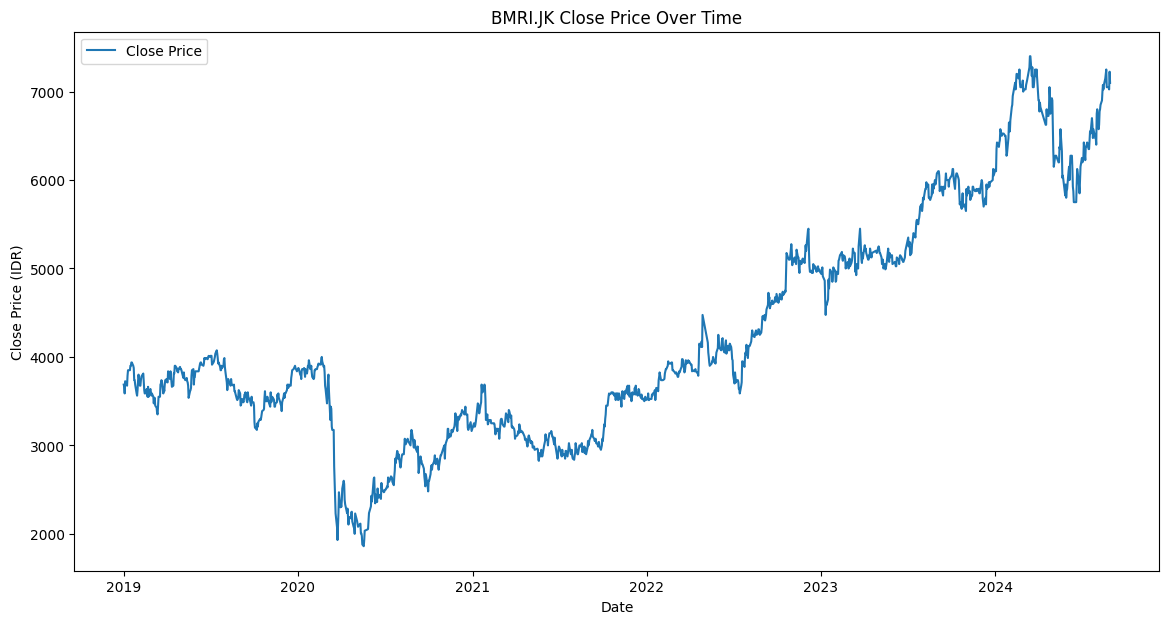

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(data['Close'], label='Close Price')
plt.title('BMRI.JK Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price (IDR)')
plt.legend()
plt.show()

Memeriksa dan menampilkan jumlah nilai yang hilang (missing values) di setiap kolom dataset.

In [ ]:
missing_values = data.isnull().sum()
print("Missing values in each column:")
print(missing_values)

Missing values in each column:
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


Menampilkan statistik deskriptif untuk kolom 'Close', yang mencakup ukuran seperti rata-rata, standar deviasi, dan nilai-nilai persentil.

In [ ]:
print(data['Close'].describe())

count    1386.000000
mean     4206.996753
std      1264.463969
min      1860.000000
25%      3287.500000
50%      3831.250000
75%      5100.000000
max      7400.000000
Name: Close, dtype: float64


# **Preprocessing Data**
Menggunakan MinMaxScaler untuk menskalakan harga penutupan ('Close Price') ke rentang antara 0 dan 1, kemudian memplot harga penutupan yang telah diskalakan dari waktu ke waktu.

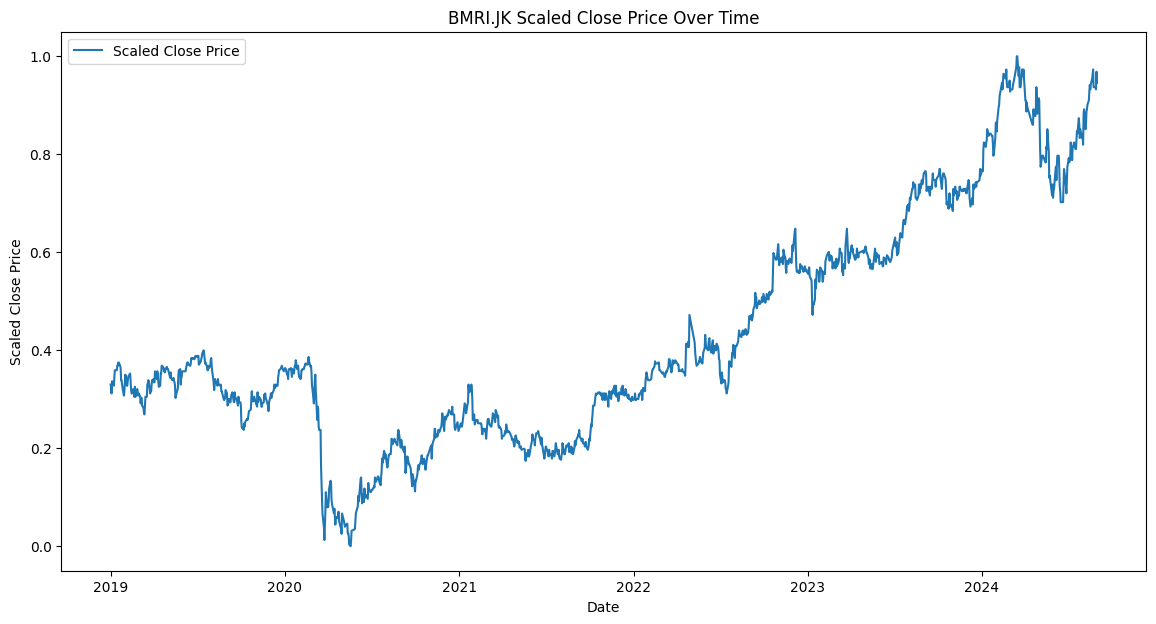

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data['Close'].values.reshape(-1, 1))

data['Close_Scaled'] = data_scaled

plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Close_Scaled'], label='Scaled Close Price')
plt.title('BMRI.JK Scaled Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Scaled Close Price')
plt.legend()
plt.show()

# **Data Separation**
Membagi data menjadi set pelatihan dan pengujian

Membagi dataset menjadi data pelatihan dan data pengujian dengan proporsi 80% untuk pelatihan dan 20% untuk pengujian. Menampilkan ukuran masing-masing subset data.

In [ ]:
train_size = 0.8

train_split_index = int(len(data) * train_size)

train_data = data[:train_split_index]
test_data = data[train_split_index:]

print(f"Training Data Size: {len(train_data)}")
print(f"Testing Data Size: {len(test_data)}")

Training Data Size: 1108
Testing Data Size: 278


Memvisualisasikan data pelatihan dan data pengujian yang telah diskalakan untuk harga penutupan ('Close Price') pada grafik yang sama, guna membandingkan distribusi data pelatihan dan pengujian.

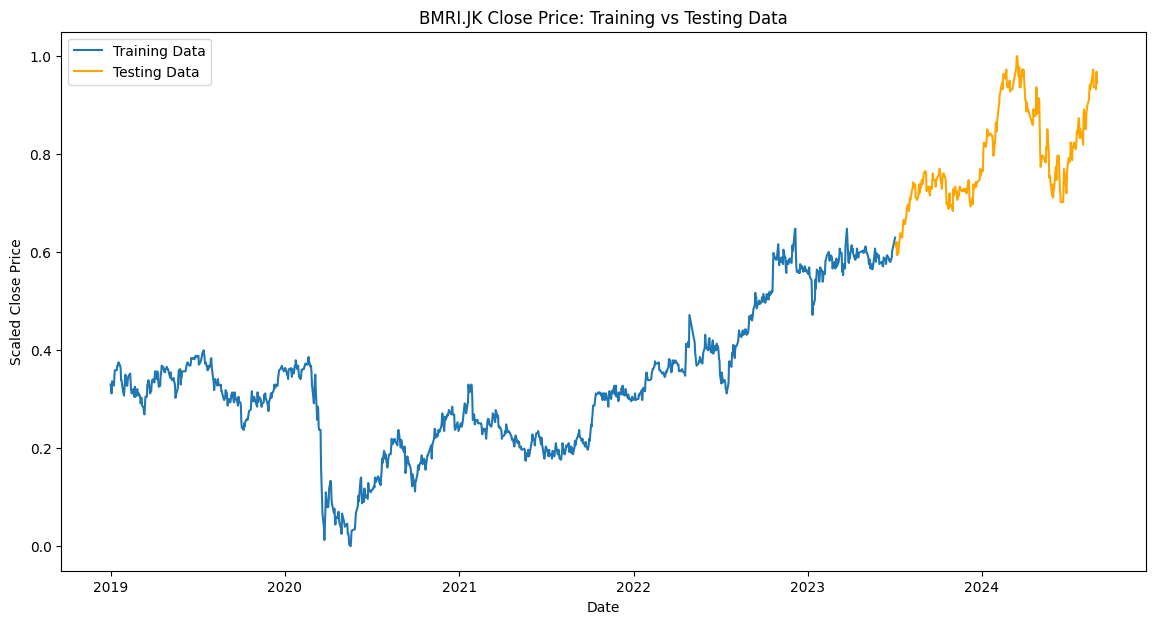

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(train_data['Close_Scaled'], label='Training Data')
plt.plot(test_data['Close_Scaled'], label='Testing Data', color='orange')
plt.title('BMRI.JK Close Price: Training vs Testing Data')
plt.xlabel('Date')
plt.ylabel('Scaled Close Price')
plt.legend()
plt.show()

Mendefinisikan fungsi untuk membuat dataset yang sesuai untuk model LSTM. Fungsi ini mengubah data time series menjadi kumpulan pasangan fitur dan target berdasarkan langkah waktu tertentu.

In [ ]:
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data)-time_step-1):
        X.append(data[i:(i+time_step), 0])
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

Mempersiapkan data pelatihan dan pengujian untuk model LSTM dengan langkah waktu (time_step) sebesar 60. Data diubah menjadi pasangan input-output, kemudian diubah bentuknya (reshaped) menjadi format 3D yang diperlukan oleh LSTM.

In [ ]:
time_step = 60

train_data = data['Close_Scaled'][:train_split_index].values.reshape(-1, 1)
test_data = data['Close_Scaled'][train_split_index:].values.reshape(-1, 1)

X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# **Modeling**
Menggunakan model time series forecasting yaitu LSTM (Long Short-Term Memory) untuk model deep learning.

Membangun model LSTM dengan dua lapisan LSTM, dropout untuk mencegah overfitting, dan lapisan dense untuk prediksi. Model ini dikompilasi menggunakan optimizer Adam dan fungsi loss mean squared error.

In [ ]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Mengatur callback EarlyStopping untuk menghentikan pelatihan lebih awal jika val_loss tidak membaik setelah 10 epoch, serta mengembalikan bobot model ke yang terbaik saat pelatihan.

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

Melatih model LSTM menggunakan data pelatihan, dengan batch size 32 dan maksimal 100 epoch. Proses pelatihan juga menggunakan data validasi untuk memantau kinerja dan menerapkan callback EarlyStopping.

In [ ]:
history = model.fit(X_train, y_train, batch_size=32, epochs=100, validation_data=(X_test, y_test), callbacks=[early_stop])

Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - loss: 0.0516 - val_loss: 0.0081
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 0.0037 - val_loss: 0.0022
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 0.0018 - val_loss: 0.0036
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.0020 - val_loss: 0.0018
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.0016 - val_loss: 0.0036
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 0.0017 - val_loss: 0.0022
Epoch 8/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - loss: 0.0014 - val_loss: 0.0026
Epoch 9/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 10/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.0015 - val_loss: 0.0021
Epoch 11/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.0013 - val_loss: 0.0022
Epoch 12/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step

Memprediksi nilai pada data pelatihan dan pengujian menggunakan model yang telah dilatih, kemudian mengembalikan nilai prediksi dan nilai sebenarnya (y_train dan y_test) ke skala aslinya dengan inverse transformasi.

In [ ]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


Memvisualisasikan data asli harga penutupan ('Close Price') untuk data pelatihan dan pengujian setelah dikembalikan ke skala aslinya, untuk membandingkan distribusi data sebenarnya di kedua subset.

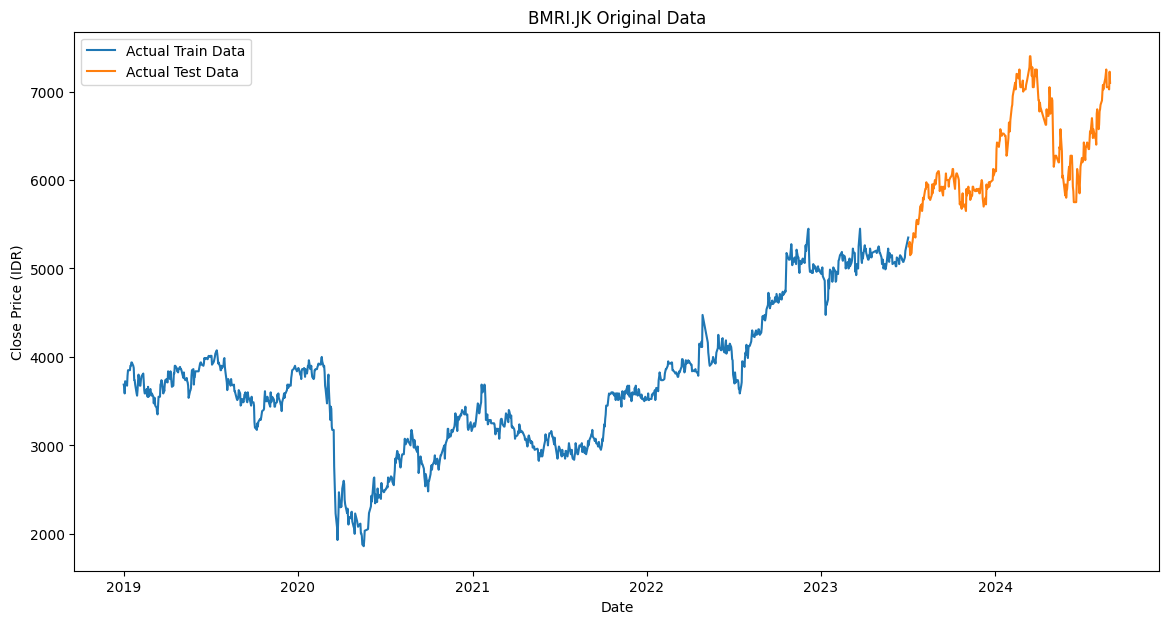

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(data.index[:train_split_index], scaler.inverse_transform(train_data), label='Actual Train Data')
plt.plot(data.index[train_split_index:], scaler.inverse_transform(test_data), label='Actual Test Data')
plt.title('BMRI.JK Original Data')
plt.xlabel('Date')
plt.ylabel('Close Price (IDR)')
plt.legend()
plt.show()

Memvisualisasikan prediksi harga penutupan ('Close Price') pada data pelatihan oleh model LSTM, dengan menempatkan hasil prediksi pada rentang waktu yang sesuai dalam dataset.

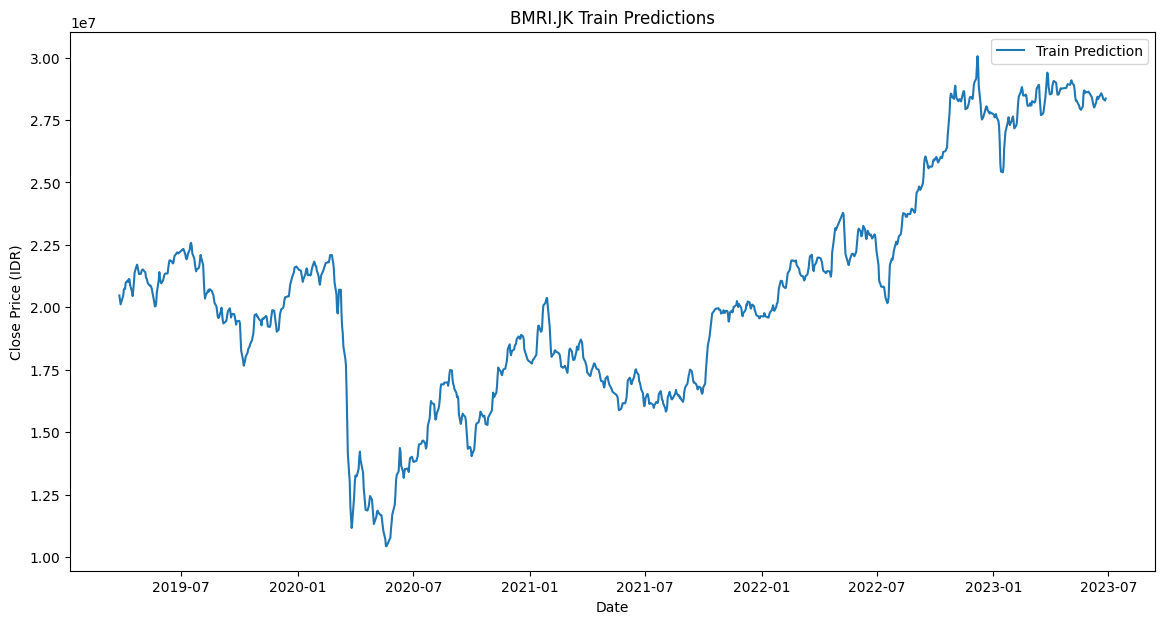

In [ ]:
plt.figure(figsize=(14, 7))
train_predict_plot = np.empty_like(data['Close_Scaled'])
train_predict_plot[:] = np.nan
train_predict_plot[time_step:time_step + len(train_predict)] = train_predict.flatten()
plt.plot(data.index, scaler.inverse_transform(train_predict_plot.reshape(-1, 1)), label='Train Prediction')
plt.title('BMRI.JK Train Predictions')
plt.xlabel('Date')
plt.ylabel('Close Price (IDR)')
plt.legend()
plt.show()

Memvisualisasikan prediksi harga penutupan ('Close Price') pada data pengujian oleh model LSTM, dengan menempatkan hasil prediksi pada rentang waktu yang sesuai dalam dataset.

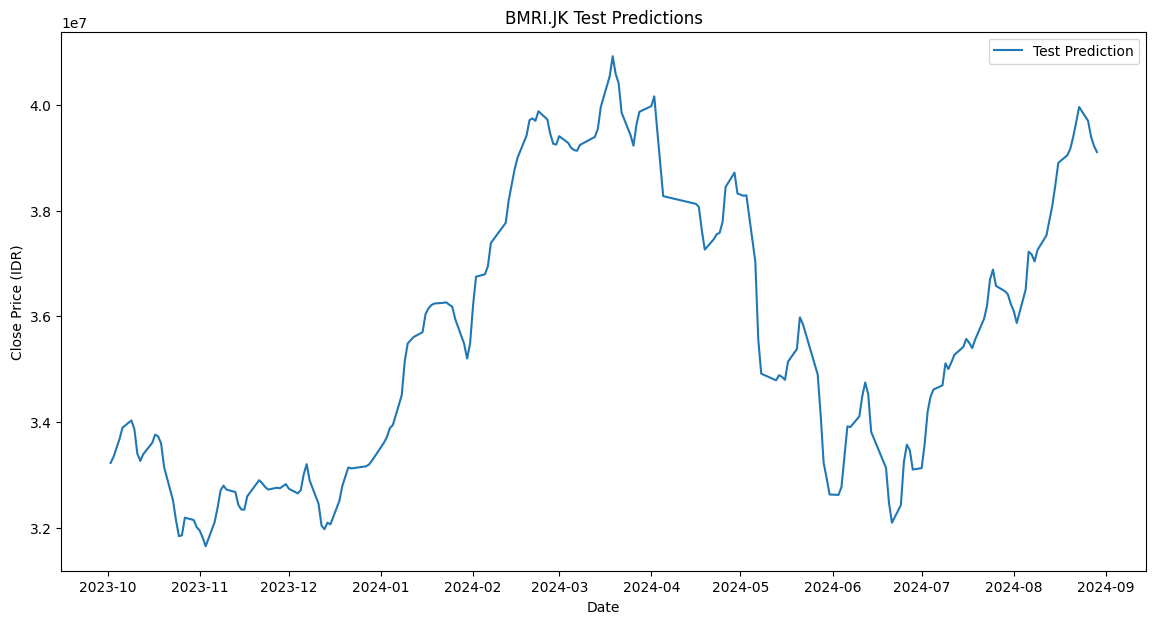

In [ ]:
plt.figure(figsize=(14, 7))
test_predict_plot = np.empty_like(data['Close_Scaled'])
test_predict_plot[:] = np.nan
test_predict_plot[train_split_index + time_step + 1:train_split_index + time_step + 1 + len(test_predict)] = test_predict.flatten()
plt.plot(data.index, scaler.inverse_transform(test_predict_plot.reshape(-1, 1)), label='Test Prediction')
plt.title('BMRI.JK Test Predictions')
plt.xlabel('Date')
plt.ylabel('Close Price (IDR)')
plt.legend()
plt.show()

Menghitung dan menampilkan Root Mean Squared Error (RMSE) untuk data pelatihan dan data pengujian, guna mengukur seberapa baik model LSTM memprediksi harga penutupan ('Close Price') dibandingkan dengan nilai sebenarnya.

In [ ]:
train_rmse = math.sqrt(mean_squared_error(y_train, train_predict))
test_rmse = math.sqrt(mean_squared_error(y_test, test_predict))

print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')

Train RMSE: 85.24134583071181
Test RMSE: 132.80238821043952


# **Evaluasi Model**
Menggunakan visualisasi plot untuk mengevaluasi kinerja model dari hasil training dan test set

Memvisualisasikan perubahan loss selama proses pelatihan untuk data pelatihan dan data validasi, guna memantau bagaimana model belajar dan apakah terjadi overfitting.

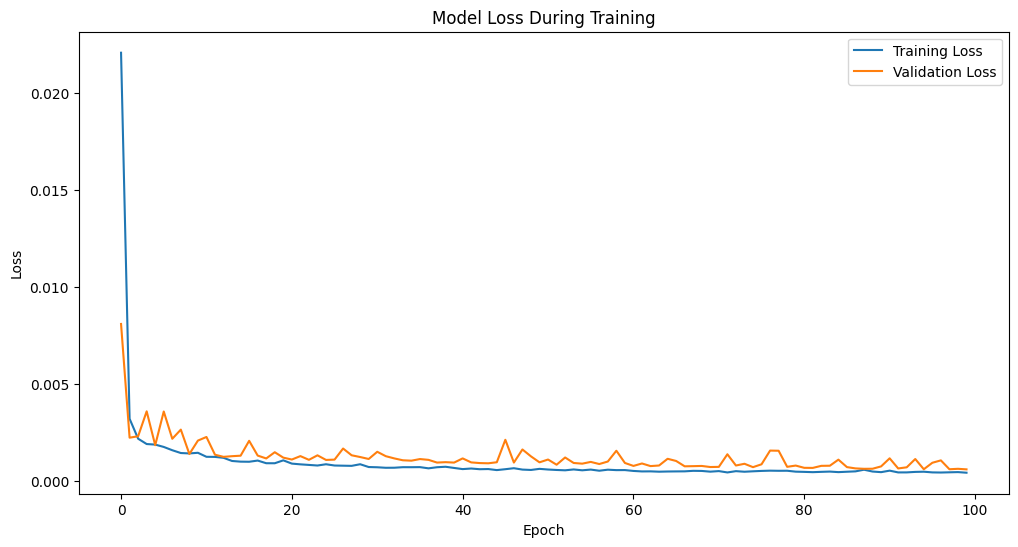

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# **Stock BMRI Price Prediction**
Menggunakan model untuk melakukan prediksi terhadap harga pasar saham BMRI pada 30 hari kedepan

Memprediksi harga penutupan ('Close Price') untuk 30 hari ke depan menggunakan model LSTM, berdasarkan data pengujian terakhir. Proses ini dilakukan secara iteratif, di mana prediksi sebelumnya digunakan sebagai input untuk prediksi berikutnya.

In [ ]:
future_input = test_data[-time_step:].reshape(1, -1)
future_input = list(future_input[0])

future_output = []
n_future = 30

for i in range(n_future):
    if len(future_input) > time_step:
        future_input = np.array(future_input[-time_step:])
        future_input = future_input.reshape((1, time_step, 1))
        pred = model.predict(future_input, verbose=0)
        future_input = list(future_input.flatten())
        future_input.extend(pred[0].tolist())
        future_output.append(pred[0][0])
    else:
        future_input = np.array(future_input)
        future_input = future_input.reshape((1, time_step, 1))
        pred = model.predict(future_input, verbose=0)
        future_input = list(future_input.flatten())
        future_input.extend(pred[0].tolist())
        future_output.append(pred[0][0])

future_output = scaler.inverse_transform(np.array(future_output).reshape(-1, 1))


Memvisualisasikan prediksi harga penutupan ('Close Price') untuk 30 hari ke depan berdasarkan hasil prediksi model LSTM, dengan menampilkan prediksi pada grafik sebagai garis merah.

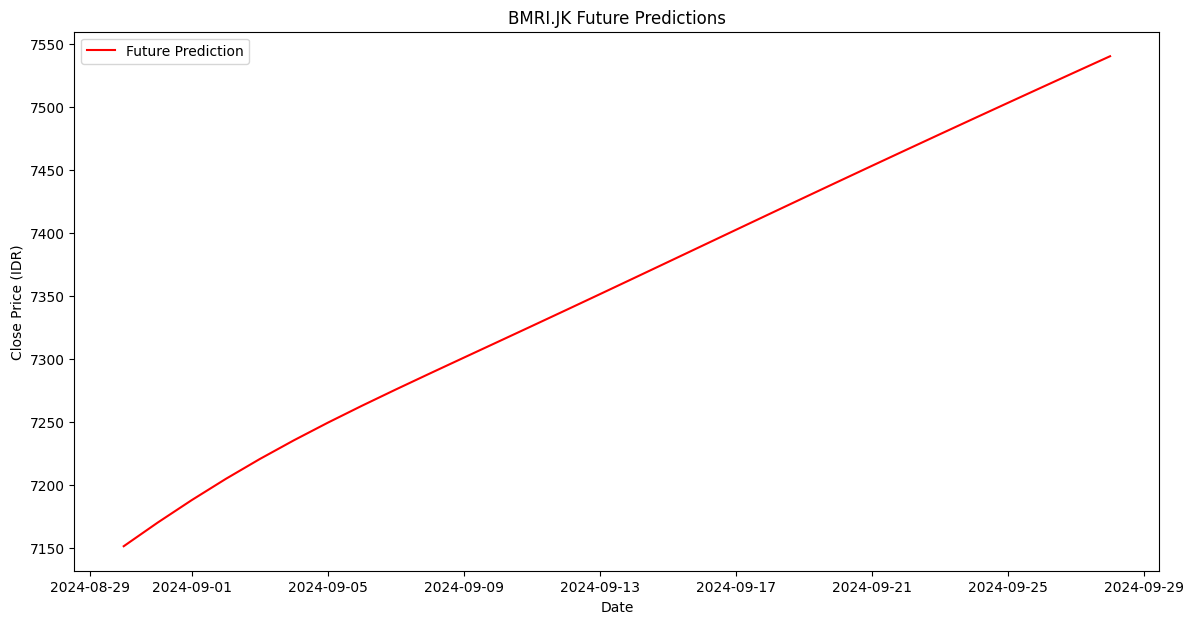

In [ ]:
plt.figure(figsize=(14, 7))

last_date = data.index[-1]
future_index = pd.date_range(start=last_date, periods=n_future + 1, freq='D')

plt.plot(future_index[1:], future_output, label='Future Prediction', color='red')

plt.title('BMRI.JK Future Predictions')
plt.xlabel('Date')
plt.ylabel('Close Price (IDR)')
plt.legend()

plt.show()